In [74]:
import os
import warnings

os.environ['PYTHONWARNINGS'] = "ignore:Unverified HTTPS request"
warnings.filterwarnings("ignore")

import pandas as pd
import sqlite3
import numpy as np
import random
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
from pandasql import sqldf
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
import random
import math
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc, roc_auc_score, log_loss
from sklearn import metrics

In [2]:
pysqldf = lambda q: sqldf(q, globals())

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
### import data
df_master = pd.read_excel('Navigation_rawdata.xlsx', parse_dates=['rtimestamp'])

In [5]:
df_master.head()

,sessionid,rtimestamp,event_type,channel,buyingcategoryid,domain
0,05bb3946-4bb4-4e1f-a04b-ba16522893c2,2021-12-08 11:29:54.310000+00:00,external_access,android native,NaN,NaN
1,05bb3946-4bb4-4e1f-a04b-ba16522893c2,2021-12-08 11:29:56.467000+00:00,product_list_search,android native,NaN,NaN
2,05bb3946-4bb4-4e1f-a04b-ba16522893c2,2021-12-08 11:29:58.620000+00:00,product_view,android native,80089006.0,Fashion & Lifestyle
3,05bb3946-4bb4-4e1f-a04b-ba16522893c2,NaT,exit,android native,NaN,NaN
4,05bb3ba4-c674-42f6-bf2a-6ba5acc56a39,2021-12-08 07:21:07.545000+00:00,product_list_search,desktop,NaN,NaN


In [6]:
df_master.shape

(833538, 6)

### Model

In [7]:
df_master.head()

,sessionid,rtimestamp,event_type,channel,buyingcategoryid,domain
0,05bb3946-4bb4-4e1f-a04b-ba16522893c2,2021-12-08 11:29:54.310000+00:00,external_access,android native,NaN,NaN
1,05bb3946-4bb4-4e1f-a04b-ba16522893c2,2021-12-08 11:29:56.467000+00:00,product_list_search,android native,NaN,NaN
2,05bb3946-4bb4-4e1f-a04b-ba16522893c2,2021-12-08 11:29:58.620000+00:00,product_view,android native,80089006.0,Fashion & Lifestyle
3,05bb3946-4bb4-4e1f-a04b-ba16522893c2,NaT,exit,android native,NaN,NaN
4,05bb3ba4-c674-42f6-bf2a-6ba5acc56a39,2021-12-08 07:21:07.545000+00:00,product_list_search,desktop,NaN,NaN


Let's sort the data to use it on further preprocess steps

In [8]:
df_master.sort_values(['sessionid', 'rtimestamp'], ascending=[True, True], inplace=True)

In [9]:
df_master.head()

,sessionid,rtimestamp,event_type,channel,buyingcategoryid,domain
28056,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:52:08.783000+00:00,home,android native,NaN,NaN
28057,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:52:17.331000+00:00,basket_view,android native,NaN,NaN
28058,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:52:41.454000+00:00,basket_view,android native,NaN,NaN
28059,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:53:10.345000+00:00,basket_view,android native,NaN,NaN
28060,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:54:14.391000+00:00,product_view,android native,80089036.0,Home & Garden


Data is actually given as a type of movement in each time step. First of all, let's aggregate data based on its session ids so that event type, channel and category ids will be represented as columns. Therefore, each column will represent type of movement in a specific step of time for unique session.

 Lets generate function to apply specific aggregations to multiple columns. 

In [10]:
def func_convert_time_based(df, column):
    df_time = pd.DataFrame(df.groupby(df.sessionid)[column].apply(lambda x: x.values)\
                            .values.tolist(), index=df.sessionid.unique()).rename_axis('sessionid').reset_index()
    df_time = df_time.rename(columns={col: 'event_' + str(col)
                                            for col in df_time.columns if col not in ['sessionid']})
    return df_time

In [11]:
df_time_channel_type = func_convert_time_based(df_master, 'event_type')
df_time_event_type = func_convert_time_based(df_master, 'channel')

In [12]:
df_time_id_type = func_convert_time_based(df_master, 'buyingcategoryid')

In [13]:
df_time_channel_type.head(2)

,sessionid,event_0,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,event_9,event_10,event_11,event_12,event_13,event_14,event_15,event_16,event_17,event_18,event_19,event_20,event_21,event_22,event_23,event_24,event_25,event_26,event_27,event_28,event_29,event_30,event_31,event_32,event_33,event_34,event_35,event_36,event_37,event_38,event_39,event_40,event_41,event_42,event_43,event_44,event_45,event_46,event_47,event_48,event_49,event_50,event_51,event_52,event_53,event_54,event_55,event_56,event_57,event_58,event_59,event_60,event_61,event_62,event_63,event_64,event_65,event_66,event_67,event_68,event_69,event_70,event_71,event_72,event_73,event_74,event_75,event_76,event_77,event_78,event_79,event_80,event_81,event_82,event_83,event_84,event_85,event_86,event_87,event_88,event_89,event_90,event_91,event_92,event_93,event_94,event_95,event_96,event_97,event_98,event_99,event_100,event_101,event_102,event_103,event_104,event_105,event_106,event_107,event_108,event_109,event_110,event_111,event_112,event_113,event_114,event_115,event_116,event_117,event_118,event_119,event_120,event_121,event_122,event_123,event_124,event_125,event_126,event_127,event_128,event_129,event_130,event_131,event_132,event_133,event_134,event_135,event_136,event_137,event_138,event_139,event_140,event_141,event_142,event_143,event_144,event_145,event_146,event_147,event_148,event_149,event_150,event_151,event_152,event_153,event_154,event_155,event_156,event_157,event_158,event_159,event_160,event_161,event_162,event_163,event_164,event_165,event_166,event_167,event_168,event_169,event_170,event_171,event_172,event_173,event_174,event_175,event_176,event_177,event_178,event_179,event_180,event_181,event_182,event_183,event_184,event_185,event_186,event_187,event_188,event_189,event_190,event_191,event_192,event_193,event_194,event_195,event_196,event_197,event_198,event_199,event_200,event_201,event_202,event_203,event_204,event_205,event_206,event_207,event_208,event_209,event_210,event_211,event_212,event_213,event_214,event_215,event_216,event_217,event_218,event_219,event_220,event_221,event_222,event_223,event_224,event_225,event_226,event_227,event_228,event_229,event_230,event_231,event_232,event_233,event_234,event_235,event_236,event_237,event_238,event_239,event_240,event_241,event_242,event_243,event_244,event_245,event_246,event_247,event_248,event_249,event_250,event_251,event_252,event_253,event_254,event_255,event_256,event_257,event_258,event_259,event_260,event_261,event_262,event_263,event_264,event_265,event_266,event_267,event_268,event_269,event_270,event_271,event_272,event_273,event_274,event_275,event_276,event_277,event_278,event_279,event_280,event_281,event_282,event_283,event_284,event_285,event_286,event_287,event_288,event_289,event_290,event_291,event_292,event_293,event_294,event_295,event_296,event_297,event_298,event_299,event_300,event_301,event_302,event_303,event_304,event_305,event_306,event_307,event_308,event_309,event_310,event_311,event_312,event_313,event_314,event_315,event_316,event_317,event_318,event_319,event_320,event_321,event_322,event_323,event_324,event_325,event_326,event_327,event_328,event_329,event_330,event_331,event_332,event_333,event_334,event_335,event_336,event_337,event_338,event_339,event_340,event_341,event_342,event_343,event_344,event_345,event_346,event_347,event_348,event_349,event_350,event_351,event_352,event_353,event_354,event_355,event_356,event_357,event_358,event_359,event_360,event_361,event_362,event_363,event_364,event_365,event_366,event_367,event_368,event_369,event_370,event_371,event_372,event_373,event_374,event_375,event_376,event_377,event_378,event_379,event_380,event_381,event_382,event_383,event_384,event_385,event_386,event_387,event_388,event_389,event_390,event_391,event_392,event_393,event_394,event_395,event_396,event_397,event_398,event_399,event_400,event_401,event_402,event_403,event_404,event_405,event_406,event_407,event_408,event_409

In [14]:
df_time_event_type.head(2)

,sessionid,event_0,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,event_9,event_10,event_11,event_12,event_13,event_14,event_15,event_16,event_17,event_18,event_19,event_20,event_21,event_22,event_23,event_24,event_25,event_26,event_27,event_28,event_29,event_30,event_31,event_32,event_33,event_34,event_35,event_36,event_37,event_38,event_39,event_40,event_41,event_42,event_43,event_44,event_45,event_46,event_47,event_48,event_49,event_50,event_51,event_52,event_53,event_54,event_55,event_56,event_57,event_58,event_59,event_60,event_61,event_62,event_63,event_64,event_65,event_66,event_67,event_68,event_69,event_70,event_71,event_72,event_73,event_74,event_75,event_76,event_77,event_78,event_79,event_80,event_81,event_82,event_83,event_84,event_85,event_86,event_87,event_88,event_89,event_90,event_91,event_92,event_93,event_94,event_95,event_96,event_97,event_98,event_99,event_100,event_101,event_102,event_103,event_104,event_105,event_106,event_107,event_108,event_109,event_110,event_111,event_112,event_113,event_114,event_115,event_116,event_117,event_118,event_119,event_120,event_121,event_122,event_123,event_124,event_125,event_126,event_127,event_128,event_129,event_130,event_131,event_132,event_133,event_134,event_135,event_136,event_137,event_138,event_139,event_140,event_141,event_142,event_143,event_144,event_145,event_146,event_147,event_148,event_149,event_150,event_151,event_152,event_153,event_154,event_155,event_156,event_157,event_158,event_159,event_160,event_161,event_162,event_163,event_164,event_165,event_166,event_167,event_168,event_169,event_170,event_171,event_172,event_173,event_174,event_175,event_176,event_177,event_178,event_179,event_180,event_181,event_182,event_183,event_184,event_185,event_186,event_187,event_188,event_189,event_190,event_191,event_192,event_193,event_194,event_195,event_196,event_197,event_198,event_199,event_200,event_201,event_202,event_203,event_204,event_205,event_206,event_207,event_208,event_209,event_210,event_211,event_212,event_213,event_214,event_215,event_216,event_217,event_218,event_219,event_220,event_221,event_222,event_223,event_224,event_225,event_226,event_227,event_228,event_229,event_230,event_231,event_232,event_233,event_234,event_235,event_236,event_237,event_238,event_239,event_240,event_241,event_242,event_243,event_244,event_245,event_246,event_247,event_248,event_249,event_250,event_251,event_252,event_253,event_254,event_255,event_256,event_257,event_258,event_259,event_260,event_261,event_262,event_263,event_264,event_265,event_266,event_267,event_268,event_269,event_270,event_271,event_272,event_273,event_274,event_275,event_276,event_277,event_278,event_279,event_280,event_281,event_282,event_283,event_284,event_285,event_286,event_287,event_288,event_289,event_290,event_291,event_292,event_293,event_294,event_295,event_296,event_297,event_298,event_299,event_300,event_301,event_302,event_303,event_304,event_305,event_306,event_307,event_308,event_309,event_310,event_311,event_312,event_313,event_314,event_315,event_316,event_317,event_318,event_319,event_320,event_321,event_322,event_323,event_324,event_325,event_326,event_327,event_328,event_329,event_330,event_331,event_332,event_333,event_334,event_335,event_336,event_337,event_338,event_339,event_340,event_341,event_342,event_343,event_344,event_345,event_346,event_347,event_348,event_349,event_350,event_351,event_352,event_353,event_354,event_355,event_356,event_357,event_358,event_359,event_360,event_361,event_362,event_363,event_364,event_365,event_366,event_367,event_368,event_369,event_370,event_371,event_372,event_373,event_374,event_375,event_376,event_377,event_378,event_379,event_380,event_381,event_382,event_383,event_384,event_385,event_386,event_387,event_388,event_389,event_390,event_391,event_392,event_393,event_394,event_395,event_396,event_397,event_398,event_399,event_400,event_401,event_402,event_403,event_404,event_405,event_406,event_407,event_408,event_409

In [15]:
df_time_id_type.head(2)

,sessionid,event_0,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,event_9,event_10,event_11,event_12,event_13,event_14,event_15,event_16,event_17,event_18,event_19,event_20,event_21,event_22,event_23,event_24,event_25,event_26,event_27,event_28,event_29,event_30,event_31,event_32,event_33,event_34,event_35,event_36,event_37,event_38,event_39,event_40,event_41,event_42,event_43,event_44,event_45,event_46,event_47,event_48,event_49,event_50,event_51,event_52,event_53,event_54,event_55,event_56,event_57,event_58,event_59,event_60,event_61,event_62,event_63,event_64,event_65,event_66,event_67,event_68,event_69,event_70,event_71,event_72,event_73,event_74,event_75,event_76,event_77,event_78,event_79,event_80,event_81,event_82,event_83,event_84,event_85,event_86,event_87,event_88,event_89,event_90,event_91,event_92,event_93,event_94,event_95,event_96,event_97,event_98,event_99,event_100,event_101,event_102,event_103,event_104,event_105,event_106,event_107,event_108,event_109,event_110,event_111,event_112,event_113,event_114,event_115,event_116,event_117,event_118,event_119,event_120,event_121,event_122,event_123,event_124,event_125,event_126,event_127,event_128,event_129,event_130,event_131,event_132,event_133,event_134,event_135,event_136,event_137,event_138,event_139,event_140,event_141,event_142,event_143,event_144,event_145,event_146,event_147,event_148,event_149,event_150,event_151,event_152,event_153,event_154,event_155,event_156,event_157,event_158,event_159,event_160,event_161,event_162,event_163,event_164,event_165,event_166,event_167,event_168,event_169,event_170,event_171,event_172,event_173,event_174,event_175,event_176,event_177,event_178,event_179,event_180,event_181,event_182,event_183,event_184,event_185,event_186,event_187,event_188,event_189,event_190,event_191,event_192,event_193,event_194,event_195,event_196,event_197,event_198,event_199,event_200,event_201,event_202,event_203,event_204,event_205,event_206,event_207,event_208,event_209,event_210,event_211,event_212,event_213,event_214,event_215,event_216,event_217,event_218,event_219,event_220,event_221,event_222,event_223,event_224,event_225,event_226,event_227,event_228,event_229,event_230,event_231,event_232,event_233,event_234,event_235,event_236,event_237,event_238,event_239,event_240,event_241,event_242,event_243,event_244,event_245,event_246,event_247,event_248,event_249,event_250,event_251,event_252,event_253,event_254,event_255,event_256,event_257,event_258,event_259,event_260,event_261,event_262,event_263,event_264,event_265,event_266,event_267,event_268,event_269,event_270,event_271,event_272,event_273,event_274,event_275,event_276,event_277,event_278,event_279,event_280,event_281,event_282,event_283,event_284,event_285,event_286,event_287,event_288,event_289,event_290,event_291,event_292,event_293,event_294,event_295,event_296,event_297,event_298,event_299,event_300,event_301,event_302,event_303,event_304,event_305,event_306,event_307,event_308,event_309,event_310,event_311,event_312,event_313,event_314,event_315,event_316,event_317,event_318,event_319,event_320,event_321,event_322,event_323,event_324,event_325,event_326,event_327,event_328,event_329,event_330,event_331,event_332,event_333,event_334,event_335,event_336,event_337,event_338,event_339,event_340,event_341,event_342,event_343,event_344,event_345,event_346,event_347,event_348,event_349,event_350,event_351,event_352,event_353,event_354,event_355,event_356,event_357,event_358,event_359,event_360,event_361,event_362,event_363,event_364,event_365,event_366,event_367,event_368,event_369,event_370,event_371,event_372,event_373,event_374,event_375,event_376,event_377,event_378,event_379,event_380,event_381,event_382,event_383,event_384,event_385,event_386,event_387,event_388,event_389,event_390,event_391,event_392,event_393,event_394,event_395,event_396,event_397,event_398,event_399,event_400,event_401,event_402,event_403,event_404,event_405,event_406,event_407,event_408,event_409

Our task is to determine which type of action can increase the probability of purchase. I will slice the data frame for  each session on time steps of 5. Therefore, each row will represent 5 sequential movements of the user. This conversion will be applied to event_type, channel and buyingcategoryid columns. 

At the end, there will be multiple rows for each sessionid.

It is important to state that every customer doesn’t have the same exact number of movements on the system so that data will be generated from the session up to the point that they left the system. 

In [16]:
def func_convert_row_format(df, time_lag, max_number_to_go, column_name):
    df_time_row =pd.DataFrame()
    j = 1
    renamed_column = ['sessionid'] + [column_name+ '_t_' + str(i) for i in range(1, time_lag+1)]
    for i in range(0, max_number_to_go, time_lag):
        column_list = ['sessionid'] + ['event_' + str(i) for i in range(i, i+time_lag)]
        df_tmp = df[column_list].copy()
        df_tmp.drop(df_tmp[df_tmp[column_list[1]].isnull()].index, inplace = True)
        df_tmp.columns = renamed_column
        df_tmp['time_index'] = 't' + str(j)  
        df_time_row = pd.concat([df_time_row, df_tmp], axis=0)
        j +=1
        
    return df_time_row

In [17]:
df_time_row_event = func_convert_row_format(df_time_channel_type, 5, 600, 'channel')

In [18]:
df_time_row_channel = func_convert_row_format(df_time_event_type, 5, 600, 'event_type')

In [19]:
df_time_row_event.head()

,sessionid,channel_t_1,channel_t_2,channel_t_3,channel_t_4,channel_t_5,time_index
0,00000221-c499-4158-967d-cf8efe956e66,home,basket_view,basket_view,basket_view,product_view,t1
1,00000270-cadc-4dec-a188-0634f74aebf9,external_access,home,product_view,home,exit,t1
2,00000e40-d6d9-4568-bd34-74c283694341,external_access,product_list_search,home,exit,None,t1
3,00001276-4e8f-4dad-a1f5-725d34fa3d95,product_view,exit,None,None,None,t1
4,000016ff-1ee3-41bc-9061-525e3184f74d,home,ordertracking,exit,None,None,t1


In [20]:
df_time_row_channel.head()

,sessionid,event_type_t_1,event_type_t_2,event_type_t_3,event_type_t_4,event_type_t_5,time_index
0,00000221-c499-4158-967d-cf8efe956e66,android native,android native,android native,android native,android native,t1
1,00000270-cadc-4dec-a188-0634f74aebf9,android native,android native,android native,android native,android native,t1
2,00000e40-d6d9-4568-bd34-74c283694341,android native,android native,android native,android native,None,t1
3,00001276-4e8f-4dad-a1f5-725d34fa3d95,desktop,desktop,None,None,None,t1
4,000016ff-1ee3-41bc-9061-525e3184f74d,ios native,ios native,ios native,None,None,t1


For the buyingcategoryid column, dropping the rows that has null values at specific isn’t appropriate so that I will apply slight modification to aggregation function

 I will get rid of redundant rows in merging part. 

In [21]:
def func_convert_row_format_id(df, time_lag, max_number_to_go, column_name):
    df_time_row =pd.DataFrame()
    j = 1
    renamed_column = ['sessionid'] + [column_name+ '_t_' + str(i) for i in range(1, time_lag+1)]
    for i in range(0, max_number_to_go, time_lag):
        column_list = ['sessionid'] + ['event_' + str(i) for i in range(i, i+time_lag)]
        df_tmp = df[column_list].copy()
        #df_tmp.drop(df_tmp[df_tmp[column_list[1]].isnull()].index, inplace = True)
        df_tmp.columns = renamed_column
        df_tmp['time_index'] = 't' + str(j)  
        df_time_row = pd.concat([df_time_row, df_tmp], axis=0)
        j +=1
        
    return df_time_row

In [22]:
df_time_row_id = func_convert_row_format_id(df_time_id_type, 5, 600, 'buyingcategoryid')

In [23]:
df_time_row_id.head(2)

,sessionid,buyingcategoryid_t_1,buyingcategoryid_t_2,buyingcategoryid_t_3,buyingcategoryid_t_4,buyingcategoryid_t_5,time_index
0,00000221-c499-4158-967d-cf8efe956e66,NaN,NaN,NaN,NaN,80089036.0,t1
1,00000270-cadc-4dec-a188-0634f74aebf9,NaN,NaN,80758003.0,NaN,NaN,t1


Lets create merged dataframe by left join

In [24]:
df_time_row_channel.head(1)

,sessionid,event_type_t_1,event_type_t_2,event_type_t_3,event_type_t_4,event_type_t_5,time_index
0,00000221-c499-4158-967d-cf8efe956e66,android native,android native,android native,android native,android native,t1


In [25]:
df_time_row_event.head(1)

,sessionid,channel_t_1,channel_t_2,channel_t_3,channel_t_4,channel_t_5,time_index
0,00000221-c499-4158-967d-cf8efe956e66,home,basket_view,basket_view,basket_view,product_view,t1


In [26]:
df_time_row_id.head(1)

,sessionid,buyingcategoryid_t_1,buyingcategoryid_t_2,buyingcategoryid_t_3,buyingcategoryid_t_4,buyingcategoryid_t_5,time_index
0,00000221-c499-4158-967d-cf8efe956e66,NaN,NaN,NaN,NaN,80089036.0,t1


In [27]:
df_merged = df_time_row_channel.merge(df_time_row_event, 
                                  how = 'left',
                                  left_on = ['sessionid', 'time_index'],
                                  right_on = ['sessionid', 'time_index'])

In [28]:
df_merged = df_merged.merge(df_time_row_id, 
                                  how = 'left',
                                  left_on = ['sessionid', 'time_index'],
                                  right_on = ['sessionid', 'time_index'])

In [29]:
df_merged.sort_values(['sessionid', 'time_index'], ascending=[True, True], inplace=True)

In [30]:
df_merged.head()

,sessionid,event_type_t_1,event_type_t_2,event_type_t_3,event_type_t_4,event_type_t_5,time_index,channel_t_1,channel_t_2,channel_t_3,channel_t_4,channel_t_5,buyingcategoryid_t_1,buyingcategoryid_t_2,buyingcategoryid_t_3,buyingcategoryid_t_4,buyingcategoryid_t_5
0,00000221-c499-4158-967d-cf8efe956e66,android native,android native,android native,android native,android native,t1,home,basket_view,basket_view,basket_view,product_view,NaN,NaN,NaN,NaN,80089036.0
40000,00000221-c499-4158-967d-cf8efe956e66,android native,android native,android native,android native,android native,t2,basket_view,basket_view,order_result,basket_view,product_view,NaN,NaN,NaN,NaN,80089022.0
66278,00000221-c499-4158-967d-cf8efe956e66,android native,android native,android native,android native,android native,t3,basket_view,home,home,ordertracking,exit,NaN,NaN,NaN,NaN,NaN
1,00000270-cadc-4dec-a188-0634f74aebf9,android native,android native,android native,android native,android native,t1,external_access,home,product_view,home,exit,NaN,NaN,80758003.0,NaN,NaN
2,00000e40-d6d9-4568-bd34-74c283694341,android native,android native,android native,android native,None,t1,external_access,product_list_search,home,exit,None,NaN,NaN,NaN,NaN,NaN


I will train the model to predict whether there will be purchase in the upcoming 5 time steps or not. Therefore I will remove the rows of each session after occurence of order_result string in any of the channel columns. Because this string represents that customer bought a product from a website so that  model will definitely overfit to this string. In addition my population will consist of 50 time steps (time_index=10)of each session. This value is actually represent the 80 percent of data


In [31]:
df_merged['label'] = df_merged[['channel_t_1', 'channel_t_2', 'channel_t_3', 'channel_t_4','channel_t_5']]\
                    .apply(lambda x: x.str.contains('order_result',case=False)).any(axis=1).astype(int)

In [32]:
df_merged.head()

,sessionid,event_type_t_1,event_type_t_2,event_type_t_3,event_type_t_4,event_type_t_5,time_index,channel_t_1,channel_t_2,channel_t_3,channel_t_4,channel_t_5,buyingcategoryid_t_1,buyingcategoryid_t_2,buyingcategoryid_t_3,buyingcategoryid_t_4,buyingcategoryid_t_5,label
0,00000221-c499-4158-967d-cf8efe956e66,android native,android native,android native,android native,android native,t1,home,basket_view,basket_view,basket_view,product_view,NaN,NaN,NaN,NaN,80089036.0,0
40000,00000221-c499-4158-967d-cf8efe956e66,android native,android native,android native,android native,android native,t2,basket_view,basket_view,order_result,basket_view,product_view,NaN,NaN,NaN,NaN,80089022.0,1
66278,00000221-c499-4158-967d-cf8efe956e66,android native,android native,android native,android native,android native,t3,basket_view,home,home,ordertracking,exit,NaN,NaN,NaN,NaN,NaN,0
1,00000270-cadc-4dec-a188-0634f74aebf9,android native,android native,android native,android native,android native,t1,external_access,home,product_view,home,exit,NaN,NaN,80758003.0,NaN,NaN,0
2,00000e40-d6d9-4568-bd34-74c283694341,android native,android native,android native,android native,None,t1,external_access,product_list_search,home,exit,None,NaN,NaN,NaN,NaN,NaN,0


Drop the rows which have only t1 values.

In [33]:
droped_session = df_merged.groupby('sessionid').agg({'time_index':'max'}).reset_index()

In [34]:
droped_session.head()

,sessionid,time_index
0,00000221-c499-4158-967d-cf8efe956e66,t3
1,00000270-cadc-4dec-a188-0634f74aebf9,t1
2,00000e40-d6d9-4568-bd34-74c283694341,t1
3,00001276-4e8f-4dad-a1f5-725d34fa3d95,t1
4,000016ff-1ee3-41bc-9061-525e3184f74d,t1


In [35]:
droped_session = list(droped_session[droped_session.time_index == 't1'].sessionid)

In [36]:
df_merged = df_merged[~df_merged.sessionid.isin(droped_session)].copy()

In [37]:
df_merged.sort_values(['sessionid', 'time_index'], ascending=[True, True], inplace=True)

In [38]:
df_merged.head()

,sessionid,event_type_t_1,event_type_t_2,event_type_t_3,event_type_t_4,event_type_t_5,time_index,channel_t_1,channel_t_2,channel_t_3,channel_t_4,channel_t_5,buyingcategoryid_t_1,buyingcategoryid_t_2,buyingcategoryid_t_3,buyingcategoryid_t_4,buyingcategoryid_t_5,label
0,00000221-c499-4158-967d-cf8efe956e66,android native,android native,android native,android native,android native,t1,home,basket_view,basket_view,basket_view,product_view,NaN,NaN,NaN,NaN,80089036.0,0
40000,00000221-c499-4158-967d-cf8efe956e66,android native,android native,android native,android native,android native,t2,basket_view,basket_view,order_result,basket_view,product_view,NaN,NaN,NaN,NaN,80089022.0,1
66278,00000221-c499-4158-967d-cf8efe956e66,android native,android native,android native,android native,android native,t3,basket_view,home,home,ordertracking,exit,NaN,NaN,NaN,NaN,NaN,0
5,00001720-f212-477e-914d-0082ff5e85e8,mobile,mobile,mobile,mobile,mobile,t1,product_view,product_view,product_view,product_view,addtocart,80089003.0,80089003.0,80089003.0,80089003.0,80089003.0,0
40001,00001720-f212-477e-914d-0082ff5e85e8,mobile,mobile,mobile,mobile,mobile,t2,product_list_category,product_view,basket_view,order_result,basket_view,NaN,80089003.0,NaN,NaN,NaN,1


There can be an increase in the number of features. For example, frequencies of events and channels can be generated. 

In [39]:
df_merged['label'] = df_merged.groupby('sessionid')['label'].shift(-1,)

In [40]:
df_merged.drop(df_merged[df_merged['label'].isnull()].index, inplace = True)

In [41]:
df_merged.head()

,sessionid,event_type_t_1,event_type_t_2,event_type_t_3,event_type_t_4,event_type_t_5,time_index,channel_t_1,channel_t_2,channel_t_3,channel_t_4,channel_t_5,buyingcategoryid_t_1,buyingcategoryid_t_2,buyingcategoryid_t_3,buyingcategoryid_t_4,buyingcategoryid_t_5,label
0,00000221-c499-4158-967d-cf8efe956e66,android native,android native,android native,android native,android native,t1,home,basket_view,basket_view,basket_view,product_view,NaN,NaN,NaN,NaN,80089036.0,1.0
40000,00000221-c499-4158-967d-cf8efe956e66,android native,android native,android native,android native,android native,t2,basket_view,basket_view,order_result,basket_view,product_view,NaN,NaN,NaN,NaN,80089022.0,0.0
5,00001720-f212-477e-914d-0082ff5e85e8,mobile,mobile,mobile,mobile,mobile,t1,product_view,product_view,product_view,product_view,addtocart,80089003.0,80089003.0,80089003.0,80089003.0,80089003.0,1.0
40001,00001720-f212-477e-914d-0082ff5e85e8,mobile,mobile,mobile,mobile,mobile,t2,product_list_category,product_view,basket_view,order_result,basket_view,NaN,80089003.0,NaN,NaN,NaN,0.0
66279,00001720-f212-477e-914d-0082ff5e85e8,mobile,mobile,mobile,mobile,mobile,t3,basket_view,basket_view,basket_view,product_view,product_view,NaN,NaN,NaN,80089003.0,80089003.0,0.0


Fillna Values

In [43]:
all_columns = list(df_merged.columns)
req_columns = [col for col in all_columns if col.startswith('buyingcategoryid')]

In [44]:
req_columns

['buyingcategoryid_t_1',
 'buyingcategoryid_t_2',
 'buyingcategoryid_t_3',
 'buyingcategoryid_t_4',
 'buyingcategoryid_t_5']

In [45]:
for col in req_columns:
    df_merged[col] = df_merged[col].astype(str)
    df_merged[col].fillna('Unknown', inplace=True)

In [47]:
df_merged.head()

,sessionid,event_type_t_1,event_type_t_2,event_type_t_3,event_type_t_4,event_type_t_5,time_index,channel_t_1,channel_t_2,channel_t_3,channel_t_4,channel_t_5,buyingcategoryid_t_1,buyingcategoryid_t_2,buyingcategoryid_t_3,buyingcategoryid_t_4,buyingcategoryid_t_5,label
0,00000221-c499-4158-967d-cf8efe956e66,android native,android native,android native,android native,android native,t1,home,basket_view,basket_view,basket_view,product_view,nan,nan,nan,nan,80089036.0,1.0
40000,00000221-c499-4158-967d-cf8efe956e66,android native,android native,android native,android native,android native,t2,basket_view,basket_view,order_result,basket_view,product_view,nan,nan,nan,nan,80089022.0,0.0
5,00001720-f212-477e-914d-0082ff5e85e8,mobile,mobile,mobile,mobile,mobile,t1,product_view,product_view,product_view,product_view,addtocart,80089003.0,80089003.0,80089003.0,80089003.0,80089003.0,1.0
40001,00001720-f212-477e-914d-0082ff5e85e8,mobile,mobile,mobile,mobile,mobile,t2,product_list_category,product_view,basket_view,order_result,basket_view,nan,80089003.0,nan,nan,nan,0.0
66279,00001720-f212-477e-914d-0082ff5e85e8,mobile,mobile,mobile,mobile,mobile,t3,basket_view,basket_view,basket_view,product_view,product_view,nan,nan,nan,80089003.0,80089003.0,0.0


It is important to prevent information leakages so that all the time intervals of sessions will either in in train or test set.

In [135]:
sesssion_list = list(df_merged.sessionid.unique())

In [136]:
random.Random(41).shuffle(sesssion_list)

In [137]:
size = len(sesssion_list)
a = int(math.ceil(0.6 * size))
b = int(math.ceil(0.2 * size))

In [138]:
list_train = sesssion_list[0:a]
list_validation = sesssion_list[a:a+b]
list_test = sesssion_list[a+b:]

In [166]:
df_model = df_merged.copy()

In [168]:
all_columns = list(df_model.columns)
feature_columns = [col for col in all_columns if 'label' not in col]
target_columns = ['label']
event_columns = [col for col in all_columns if 'event' in col]
channel_columns = [col for col in all_columns if 'channel' in col]

In [169]:
for col in event_columns+channel_columns:
    df_model[col].fillna('unknown', inplace=True)

In [170]:
df_train = df_model[df_model.sessionid.isin(list_train)].copy()
df_val = df_model[df_model.sessionid.isin(list_validation)].copy()
df_test = df_model[df_model.sessionid.isin(list_test)].copy()

Generate Model

In [171]:
df_merged.head()

,sessionid,event_type_t_1,event_type_t_2,event_type_t_3,event_type_t_4,event_type_t_5,time_index,channel_t_1,channel_t_2,channel_t_3,channel_t_4,channel_t_5,buyingcategoryid_t_1,buyingcategoryid_t_2,buyingcategoryid_t_3,buyingcategoryid_t_4,buyingcategoryid_t_5,label
0,00000221-c499-4158-967d-cf8efe956e66,android native,android native,android native,android native,android native,t1,home,basket_view,basket_view,basket_view,product_view,nan,nan,nan,nan,80089036.0,1.0
40000,00000221-c499-4158-967d-cf8efe956e66,android native,android native,android native,android native,android native,t2,basket_view,basket_view,order_result,basket_view,product_view,nan,nan,nan,nan,80089022.0,0.0
5,00001720-f212-477e-914d-0082ff5e85e8,mobile,mobile,mobile,mobile,mobile,t1,product_view,product_view,product_view,product_view,addtocart,80089003.0,80089003.0,80089003.0,80089003.0,80089003.0,1.0
40001,00001720-f212-477e-914d-0082ff5e85e8,mobile,mobile,mobile,mobile,mobile,t2,product_list_category,product_view,basket_view,order_result,basket_view,nan,80089003.0,nan,nan,nan,0.0
66279,00001720-f212-477e-914d-0082ff5e85e8,mobile,mobile,mobile,mobile,mobile,t3,basket_view,basket_view,basket_view,product_view,product_view,nan,nan,nan,80089003.0,80089003.0,0.0


In [172]:
def get_X_and_y(df, feature_columns, target_column):
    """Get feature columns and target column"""

    X = df[feature_columns]
    y = df[target_column].astype(int)
    return X, y

In [173]:
X_train, y_train = get_X_and_y(df_train, feature_columns, target_columns)
X_val, y_val = get_X_and_y(df_val, feature_columns, target_columns)
X_test, y_test = get_X_and_y(df_test, feature_columns, target_columns)

In [174]:
model = CatBoostClassifier()  

In [175]:
model.fit(X_train, y_train,  eval_set=(X_val, y_val), 
            cat_features=feature_columns, logging_level="Silent")

In [176]:
def plot_feature(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('Catboost Features')
    plt.tight_layout()
    plt.show()

In [177]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    # labels, title and ticks
    sns.set()
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['non fraud', 'fraud']); ax.yaxis.set_ticklabels(['fraud', 'non fraud']);

#### It is actually important to state that model overfit data. It can be understand from feature importance plot.  Related sessionid columns can be dropped from dataframe. At the same time data, the number of features should be increased such as frequencies of categorical column. 

#### Improving model success can be applied but it is out of scope for this case study. Moreover, SHAP values should be applied to convert models to more understandable formats. 

In [181]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(10, 10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [182]:
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
y_pred = pd.DataFrame((preds>= 0.5).astype(int))
roc_auc = metrics.auc(fpr, tpr)
print("roc_auc score", roc_auc)

roc_auc score 0.8022607798455881


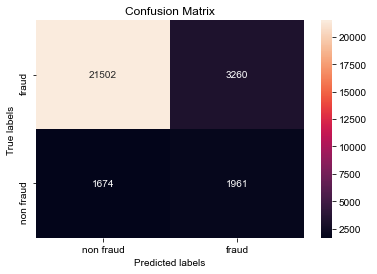

In [183]:
plot_confusion_matrix(y_test, y_pred)

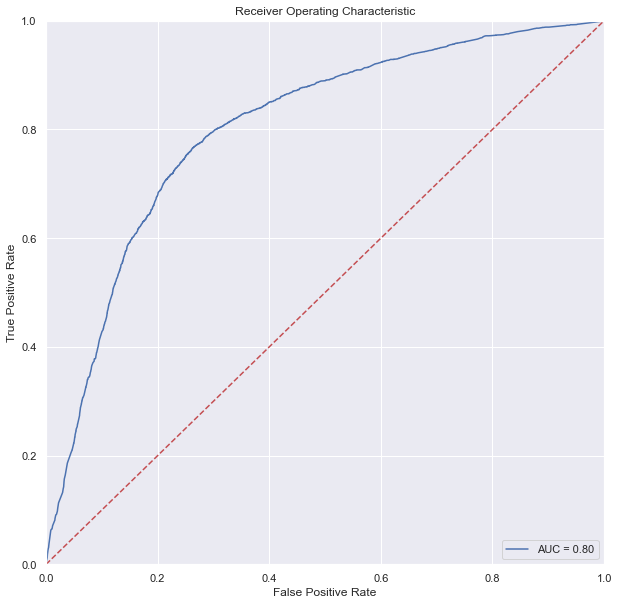

In [184]:
plot_roc_curve(fpr, tpr, roc_auc)

In [ ]:
plot_feature(model, X_test , num = 20)